In [2]:
import numpy as np
import os
import pandas as pd
from google.cloud import storage


In [3]:
base_dir = "../../raw_data/"


In [8]:
dfs = []
for i in range(1, 7):
    murs_path = os.path.join(base_dir, f"maquette{i}", f"murs{i}.csv")
    if os.path.exists(murs_path):
        # Cherche la ligne d'en-tête réelle
        with open(murs_path, encoding="utf-8") as f:
            for idx, line in enumerate(f):
                if line.startswith("Id;"):
                    header_row = idx
                    break
        try:
            df = pd.read_csv(murs_path, sep=';', decimal=",", header=header_row)
            dfs.append(df)
            print(f"Chargé : {murs_path} ({df.shape[0]} lignes, {df.shape[1]} colonnes)")
            #print(df.head())
        except Exception as e:
            print(f"Erreur de parsing : {murs_path} -> {e}")
    else:
        print(f"Fichier non trouvé : {murs_path}")

if dfs:
    murs_concat = pd.concat(dfs, ignore_index=True)
    print(f"Total concaténé : {murs_concat.shape[0]} lignes, {murs_concat.shape[1]} colonnes")
else:
    murs_concat = pd.DataFrame()
    print("Aucun fichier murs.csv trouvé.")

#murs_concat.sample(3)

Chargé : ../../raw_data/maquette1/murs1.csv (1589 lignes, 146 colonnes)
Chargé : ../../raw_data/maquette2/murs2.csv (215 lignes, 149 colonnes)
Chargé : ../../raw_data/maquette3/murs3.csv (203 lignes, 143 colonnes)
Chargé : ../../raw_data/maquette4/murs4.csv (312 lignes, 96 colonnes)
Chargé : ../../raw_data/maquette5/murs5.csv (345 lignes, 94 colonnes)
Chargé : ../../raw_data/maquette6/murs6.csv (203 lignes, 91 colonnes)
Total concaténé : 2867 lignes, 160 colonnes


In [15]:
#murs_concat['013EC_Localisation'].unique()
murs_concat.columns

Index(['Id', '011EC_Lot', '012EC_Ouvrage', '013EC_Localisation',
       '014EC_Mode Constructif', 'Nom', 'Hauteur', 'Epaisseur', 'AI', 'AS',
       ...
       'EIF_STR - Impact', 'EC_Type de Mur', 'ID MONTAGE',
       'Désignation système', 'Réf DT', 'Nature_Ouvrage', 'Batiment',
       'Mur armé', 'Affichage poteau', 'NIVEAU_STRUCTURE'],
      dtype='object', length=160)

In [16]:
colonnes_a_garder = [
    "Epaisseur",
    "Sols en intersection",
    "Sols coupés (u)",
    "Sols coupants (u)",
    "Sol au-dessus",
    "Sol en-dessous",
    "Fenêtres",
    "Portes",
    "Ouvertures",
    "Murs imbriqués",
    "Mur multicouche",
    "Profil modifié",
    "Extension inférieure",
    "Extension supérieure",
    "Partie inférieure attachée",
    "Partie supérieure attachée",
    "Décalage supérieur",
    "Décalage inférieur",
    "Matériau structurel"
]

# On ne garde que les colonnes présentes dans le DataFrame
#murs_concat = murs_concat[[col for col in colonnes_a_garder if col in murs_concat.columns]]

In [17]:
murs_concat["Matériau structurel"].unique()

array(['ECSA - Béton Voiles', 'ECSA - Béton Non porteur', 'EC - Béton',
       '<Par catégorie>', 'Maçonnerie - Voile BA',
       'Blocs béton manufacturés', 'C25/30', 'Maçonnerie'], dtype=object)

In [27]:
murs_concat[['Hauteur','Epaisseur','Sol au-dessus','Sol en-dessous','Fenêtres','Portes','Ouvertures']]

,Hauteur,Epaisseur,Sol au-dessus,Sol en-dessous,Fenêtres,Portes,Ouvertures
0,2.88,0.20,1,1,0,0,0
1,2.88,0.20,0,1,0,0,0
2,2.88,0.20,1,1,0,1,0
3,2.88,0.20,1,1,0,1,0
4,2.88,0.20,0,1,0,0,0
...,...,...,...,...,...,...,...
2862,3.64,0.20,0,0,0,0,0
2863,3.73,0.20,0,1,2,0,0
2864,3.73,0.20,0,1,0,0,0
2865,3.73,0.18,0,1,0,1,0


In [ ]:
murs_concat['Sol en-dessous'] = murs_concat['Sol en-dessous'].apply(lambda i: 0 if i == False else 1)


In [26]:

murs_concat['Sol au-dessus'] = murs_concat['Sol au-dessus'].apply(lambda i: 0 if i == False else 1)


In [ ]:
all_features = murs_concat.keys().to_list()
to_keep = ['Surface','Hauteur','Epaisseur','Sol au-dessus','Sol en-dessous','Fenêtres','Portes','Ouvertures']
to_exp =  ['Volume', 'Surface','Hauteur', 'Longueur','Largeur']
family =  ['Famille et type', 'Famille']
y = ["Matériau structurel"]

In [28]:
y = murs_concat["Matériau structurel"]
X = murs_concat[to_keep]

In [30]:
y

0         ECSA - Béton Voiles
1         ECSA - Béton Voiles
2         ECSA - Béton Voiles
3         ECSA - Béton Voiles
4         ECSA - Béton Voiles
                ...          
2862    Maçonnerie - Voile BA
2863    Maçonnerie - Voile BA
2864    Maçonnerie - Voile BA
2865    Maçonnerie - Voile BA
2866    Maçonnerie - Voile BA
Name: Matériau structurel, Length: 2867, dtype: object

In [31]:
#y to lables
y_dict = {'ECSA - Béton Voiles':0,
          'ECSA - Béton Non porteur':7,
          'EC - Béton':2,
       '<Par catégorie>':3,
       'Maçonnerie - Voile BA':4,
       'Blocs béton manufacturés':5,
       'C25/30':6,
       'Maçonnerie':1}

y_labeled = y.apply(lambda x: y_dict[x])
y_labeled


0       0
1       0
2       0
3       0
4       0
       ..
2862    4
2863    4
2864    4
2865    4
2866    4
Name: Matériau structurel, Length: 2867, dtype: int64

<Axes: xlabel='Matériau structurel', ylabel='Count'>

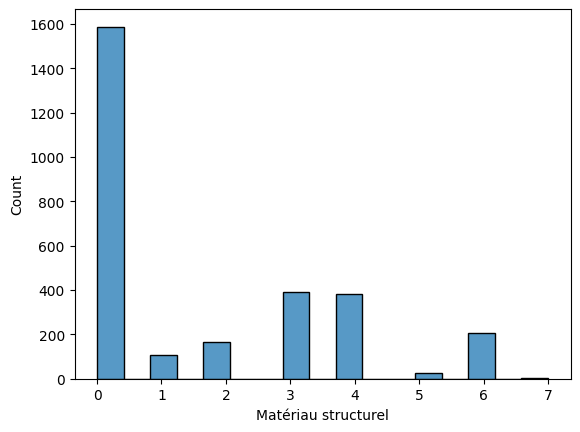

In [32]:
import seaborn as sns

sns.histplot(y_labeled)

In [33]:
y_labeled[y_labeled == 7] = 0

In [34]:
#minmax scaler test:
from sklearn.preprocessing import MinMaxScaler

minmax_scaler = MinMaxScaler()
X_scaled = minmax_scaler.fit_transform(X)


In [35]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_labeled, test_size = 0.4, random_state = 13
)


In [36]:
from xgboost import XGBClassifier

xgb_class = XGBClassifier(max_depth=10, n_estimators=100, learning_rate=0.1)

xgb_class.fit(X_train, y_train,
    #eval_set=[(X_train, y_train), (X_val, y_val)],
)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=10,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, ...)

In [37]:
y_train.unique()

array([2, 0, 3, 4, 5, 1, 6])

In [38]:
y_test.unique()

array([0, 4, 3, 1, 6, 2, 5])

In [39]:
#cross validation
from sklearn.model_selection import cross_validate

# 5-Fold Cross validate model
cv_results = cross_validate(xgb_class, X_test, y_test, cv=5)

# Scores
print(cv_results['test_score'])

# Mean of scores
cv_results['test_score'].mean()

[0.92608696 0.94782609 0.93886463 0.95633188 0.95633188]


np.float64(0.9450882855515473)

In [59]:
y_pred = xgb_class.predict(X_test)

In [60]:
y_pred

array([0, 0, 0, 0, 0, 0, 4, 3, 6, 0, 0, 4, 0, 0, 4, 0, 0, 7, 0, 2, 0, 0,
       0, 6, 6, 4, 3, 4, 0, 0, 0, 0, 0, 7, 4, 4, 4, 0, 0, 3, 4, 0, 0, 2,
       4, 3, 4, 6, 0, 0, 0, 4, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 4, 6,
       3, 0, 0, 0, 0, 0, 0, 0, 0, 3, 4, 6, 4, 4, 0, 0, 0, 0, 0, 3, 3, 6,
       3, 4, 0, 0, 0, 3, 0, 0, 4, 0, 0, 6, 5, 4, 7, 0, 0, 0, 2, 0, 0, 0,
       0, 4, 3, 7, 0, 5, 3, 0, 0, 0, 6, 2, 0, 0, 0, 0, 0, 0, 0, 0, 3, 7,
       3, 0, 3, 4, 3, 3, 3, 3, 0, 3, 0, 0, 3, 3, 6, 4, 0, 4, 0, 0, 0, 0,
       6, 3, 4, 4, 0, 0, 0, 0, 6, 0, 0, 2, 0, 0, 0, 0, 4, 0, 0, 0, 2, 0,
       7, 0, 4, 0, 0, 4, 4, 0, 0, 6, 0, 0, 7, 0, 0, 0, 2, 3, 7, 0, 0, 2,
       3, 0, 0, 0, 4, 0, 7, 3, 6, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 6, 0, 0,
       0, 4, 6, 4, 3, 4, 0, 0, 0, 4, 0, 0, 4, 0, 0, 6, 5, 3, 4, 5, 0, 3,
       5, 6, 4, 0, 0, 0, 0, 0, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 2, 4, 0, 3,
       0, 0, 3, 0, 6, 0, 4, 4, 0, 3, 0, 0, 4, 3, 2, 7, 6, 4, 0, 4, 0, 0,
       4, 7, 0, 3, 4, 0, 0, 2, 0, 0, 3, 4, 0, 0, 0,